# Capstone frame work

Overview of the dataset

The dataset contains synthetically generated images of bottles scattered around random backgrounds. The download files contain 5000 Images for each classes of bottles available. Currently there are five classes available: Plastic Bottles , Beer Bottles, Soda Bottles, Water Bottles, and Wine Bottles. I will try to add more bottle types in the future.

Datasets are of central importance to computer vision and more broadly machine learning. Particularly
with the advent of techniques that are less well understood from a theoretical point of view, raw
performance on datasets is now the major driver of new developments and the major feedback about
the state of the field.

## 1. Imports 

In [38]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#TF
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.datasets import  cifar10
from tensorflow.keras.models import load_model

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Importing image
import glob
import random
from PIL import Image
import numpy as np

#Transfer Learning
import os
import shutil
import json

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import image_dataset_from_directory

from tensorflow.keras import layers, models, regularizers

#Image genrator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


## 2. Data Readin 


In [2]:
dataset = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/bottle-synthetic-images-dataset/Bottle Images/Bottle Images',  # Correct path
    labels="inferred",
    label_mode="categorical",
    color_mode='rgb',
    subset='training',
    validation_split=0.2,
    batch_size=12,
    image_size=(224, 224),
    shuffle=True,
    interpolation="bilinear",
    seed=42,
    follow_links=False
).map(lambda x, y: (x/224, y))


Found 25000 files belonging to 5 classes.
Using 20000 files for training.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/bottle-synthetic-images-dataset/Bottle Images/Bottle Images',
    labels="inferred",
    label_mode="categorical",
    #class_names=None,# list of strings
    color_mode='rgb',
    batch_size=12,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,
    seed=42,
    subset="validation",
    interpolation="bilinear",
    follow_links=False

).map(lambda x, y: (x/224, y))

Found 25000 files belonging to 5 classes.
Using 5000 files for validation.


## 3. Data Exploration

In [4]:
for x, y in dataset:
    break

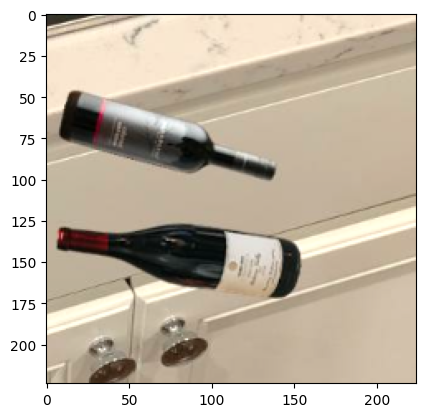

In [5]:
plt.imshow(x[10]);

## 4. Base Model

In [6]:
# Base Model
model = Sequential([
    Conv2D(64, (7, 7), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='sigmoid')  # Adjust the number of units based on the number of classes
])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 109, 109, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 105, 105, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 52, 52, 128)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 346112)            0

In [8]:
# Compile the base model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Fit the base model
model.fit(dataset, epochs=10, validation_data=val_ds)

Epoch 1/10
1667/1667 [==============================] - 103s 54ms/step - loss: 1.6214 - accuracy: 0.2014 - val_loss: 1.6100 - val_accuracy: 0.1890
Epoch 2/10
1667/1667 [==============================] - 92s 55ms/step - loss: 1.6096 - accuracy: 0.1992 - val_loss: 1.6102 - val_accuracy: 0.1890
Epoch 3/10
1667/1667 [==============================] - 92s 55ms/step - loss: 1.6096 - accuracy: 0.1984 - val_loss: 1.6101 - val_accuracy: 0.1890
Epoch 4/10
1667/1667 [==============================] - 92s 55ms/step - loss: 1.6096 - accuracy: 0.1976 - val_loss: 1.6101 - val_accuracy: 0.1890
Epoch 5/10
1667/1667 [==============================] - 92s 55ms/step - loss: 1.6096 - accuracy: 0.1981 - val_loss: 1.6101 - val_accuracy: 0.1890
Epoch 6/10
1667/1667 [==============================] - 92s 55ms/step - loss: 1.6096 - accuracy: 0.1988 - val_loss: 1.6103 - val_accuracy: 0.1890
Epoch 7/10
1667/1667 [==============================] - 92s 55ms/step - loss: 1.6096 - accuracy: 0.2002 - val_loss: 1.6102 

In [10]:
model.save('BaseObjmodelV17')

## 5. VGG16 Transferlearning 

In [11]:
# VGG16 base
conv_base = VGG16(
    weights='imagenet',
    include_top=False
)

# Make the layers non-trainable 
for layer in conv_base.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [12]:
# Get a summary of the model 
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [13]:
# Fuctional using VGG16 base 
inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x) # Preprocess the data for vgg16
x = conv_base(x) 
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(5, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [14]:
# Compile 
model.compile(
    loss='categorical_crossentropy', #sparse_categorical_crossentropy if not categorical in traing data
    optimizer='rmsprop',
    metrics=['acc']
)

In [15]:
model.fit(dataset, validation_data=val_ds, epochs=45)

Epoch 1/45
1667/1667 [==============================] - 131s 77ms/step - loss: 1.6109 - acc: 0.1989 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 2/45
1667/1667 [==============================] - 126s 76ms/step - loss: 1.6096 - acc: 0.1969 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 3/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1975 - val_loss: 1.6100 - val_acc: 0.1890
Epoch 4/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6102 - acc: 0.1966 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 5/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.2003 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 6/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1995 - val_loss: 1.6102 - val_acc: 0.1890
Epoch 7/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1978 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 8/45
1667/1667 [===================

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1974 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 21/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1972 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 22/45
 636/1667 [==========>...................] - ETA: 1:02 - loss: 1.6097 - acc: 0.1968

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1667/1667 [==============================] - 125s 75ms/step - loss: 1.6096 - acc: 0.1983 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 25/45
1393/1667 [========================>.....] - ETA: 16s - loss: 1.6096 - acc: 0.1969

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1667/1667 [==============================] - 125s 75ms/step - loss: 1.6096 - acc: 0.1988 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 28/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1972 - val_loss: 1.6100 - val_acc: 0.1890
Epoch 29/45
 436/1667 [======>.......................] - ETA: 1:14 - loss: 1.6097 - acc: 0.2001

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1667/1667 [==============================] - 125s 75ms/step - loss: 1.6096 - acc: 0.2002 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 30/45
1667/1667 [==============================] - 125s 75ms/step - loss: 1.6096 - acc: 0.1990 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 31/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1953 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 32/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1983 - val_loss: 1.6100 - val_acc: 0.1890
Epoch 33/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1975 - val_loss: 1.6101 - val_acc: 0.1890
Epoch 34/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1986 - val_loss: 1.6099 - val_acc: 0.1890
Epoch 35/45
1667/1667 [==============================] - 126s 75ms/step - loss: 1.6096 - acc: 0.1994 - val_loss: 1.6102 - val_acc: 0.1890
Epoch 36/45
1667/1667 [=======================

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 16)                401424

In [17]:
model.save('ObjmodelVGG16V17.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(12, 224, 224, 3)
(12, 5)


## 6. EfficientNet

Accuracy of model has not increased significantly. Let's try EfficientNet.

In [19]:
# An older version of EfficientNet
input_shape = (224, 224, 3)
inputs = tf.keras.Input(shape=input_shape)
x = tf.keras.applications.efficientnet.preprocess_input(inputs)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, 
    weights="imagenet", 
    input_shape=input_shape, 
    pooling='max'
)

base_model.trainable = False
x = base_model(x, training=False)
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

x = layers.Dense(
    256, 
    kernel_regularizer=regularizers.l2(l=0.016), 
    activity_regularizer=regularizers.l1(0.006),
    bias_regularizer=regularizers.l1(0.006), 
    activation='relu'
)(x)

x = layers.Dropout(rate=0.45)(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


16705208/16705208 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense_4 (Dense)             (None, 256)               327936    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                            

In [20]:
history = model.fit(x= dataset, epochs= 45, verbose= 1, validation_data= val_ds,validation_steps= None, shuffle= False)

Epoch 1/45
1667/1667 [==============================] - 68s 36ms/step - loss: 3.5178 - accuracy: 0.2810 - val_loss: 1.9133 - val_accuracy: 0.2742
Epoch 2/45
1667/1667 [==============================] - 58s 34ms/step - loss: 1.7085 - accuracy: 0.2907 - val_loss: 1.6271 - val_accuracy: 0.2936
Epoch 3/45
1667/1667 [==============================] - 58s 34ms/step - loss: 1.6030 - accuracy: 0.2880 - val_loss: 1.5735 - val_accuracy: 0.2984
Epoch 4/45
1667/1667 [==============================] - 58s 35ms/step - loss: 1.5899 - accuracy: 0.2932 - val_loss: 1.5827 - val_accuracy: 0.3004
Epoch 5/45
1667/1667 [==============================] - 58s 35ms/step - loss: 1.5814 - accuracy: 0.2941 - val_loss: 1.5687 - val_accuracy: 0.2914
Epoch 6/45
1667/1667 [==============================] - 58s 35ms/step - loss: 1.5744 - accuracy: 0.2963 - val_loss: 1.5672 - val_accuracy: 0.2960
Epoch 7/45
1667/1667 [==============================] - 58s 35ms/step - loss: 1.5711 - accuracy: 0.2971 - val_loss: 1.5507 -

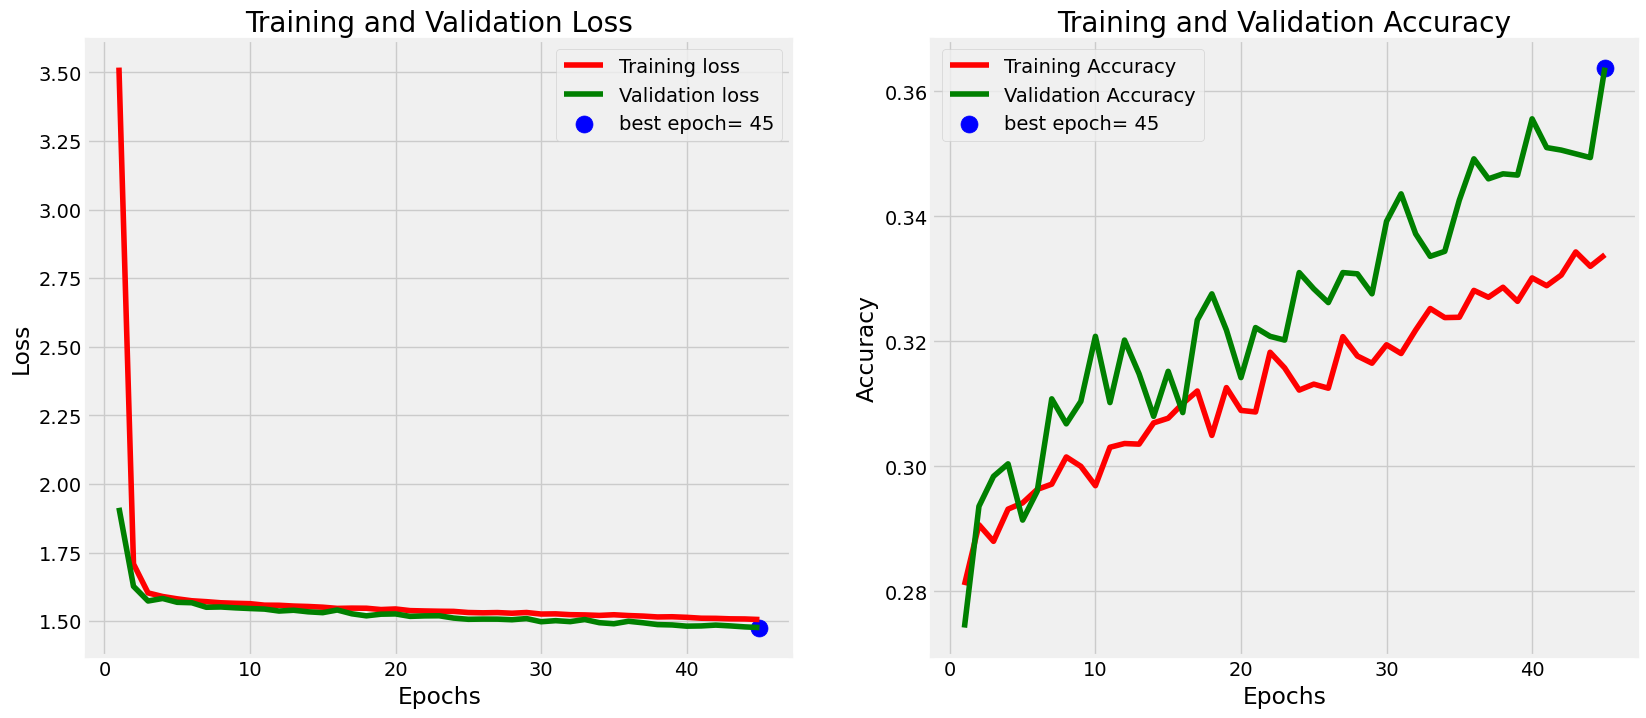

In [21]:
# Define 

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot 

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [22]:
model.save('EfficientNetObjmodelV15.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 7. EfficienctNet with image data generator

    Using data genrator to improve accuracy 

In [23]:
# Using Image Data Generator
train_datagen = ImageDataGenerator(validation_split=0.2)

In [24]:
dataset = train_datagen.flow_from_directory(
    '/kaggle/input/bottle-synthetic-images-dataset/Bottle Images/Bottle Images',
    target_size=(224, 224),
    batch_size=12,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)
val_ds = train_datagen.flow_from_directory(
    '/kaggle/input/bottle-synthetic-images-dataset/Bottle Images/Bottle Images',
    target_size=(224, 224),
    batch_size=12,
    class_mode='categorical',
    subset='validation', 
    shuffle=True,
    seed=42
)


Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [25]:
for x, y in dataset:
    break

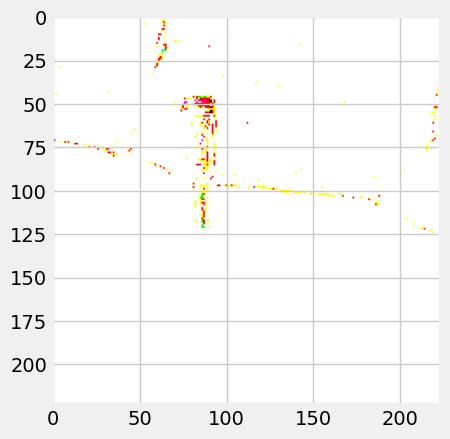

In [26]:
plt.imshow(x[1]);

In [27]:
#Agumenting the data as well
data_aug = keras.models.Sequential([
    RandomFlip('horizontal_and_vertical', input_shape=(224, 224, 3)),
    RandomRotation(0.2),
    RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
])

In [28]:
input_shape = (224,224, 3)
inputs = tf.keras.Input(shape=input_shape)
aug = data_aug(inputs)
preprocess = tf.keras.applications.efficientnet.preprocess_input(aug)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, 
    weights="imagenet", 
    input_shape=input_shape, 
    pooling='max'
)

base_model.trainable = False

# ###### Sequential ######
# model = Sequential([
#     base_model,
#     BatchNormalization(axis=-1, momentum = 0.99, epsilon=0.001),
#     Dense(256, kernel_regularizer= regularizers.l2(l=0.016),
#          activity_regularizer=regularizers.l1(0.006),
#          bias_regularizer=regularizers.l1(0.006),
#          activation="relu"),
#     Dropout(rate=0.45, seed=123),
#     Dense(5, activation="softmax")
# ])
# ########################


#baseoutput = base_model(preprocess, training=False)
baseoutput = base_model(aug, training=False)
#baseoutput = base_model(training=False)
baseoutputnormed = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(baseoutput)

base_output_normed_dense = layers.Dense(
    256, 
    kernel_regularizer=regularizers.l2(l=0.016), 
    activity_regularizer=regularizers.l1(0.006),
    bias_regularizer=regularizers.l1(0.006), 
    activation='relu'
)(baseoutputnormed)

base_output_normed_dense_drop = layers.Dropout(rate=0.45)(base_output_normed_dense)
outputs = layers.Dense(5, activation='softmax')(base_output_normed_dense_drop)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0   

In [29]:
history = model.fit(x= dataset, epochs= 50, verbose= 1, validation_data= val_ds,
                     shuffle= False)

Epoch 1/50
1667/1667 [==============================] - 74s 40ms/step - loss: 3.5382 - accuracy: 0.8727 - val_loss: 1.1210 - val_accuracy: 0.9688
Epoch 2/50
1667/1667 [==============================] - 65s 39ms/step - loss: 0.8138 - accuracy: 0.9228 - val_loss: 0.4972 - val_accuracy: 0.9698
Epoch 3/50
1667/1667 [==============================] - 65s 39ms/step - loss: 0.5392 - accuracy: 0.9322 - val_loss: 0.3912 - val_accuracy: 0.9708
Epoch 4/50
1667/1667 [==============================] - 65s 39ms/step - loss: 0.4822 - accuracy: 0.9326 - val_loss: 0.3630 - val_accuracy: 0.9734
Epoch 5/50
1667/1667 [==============================] - 65s 39ms/step - loss: 0.4592 - accuracy: 0.9344 - val_loss: 0.3434 - val_accuracy: 0.9772
Epoch 6/50
1667/1667 [==============================] - 65s 39ms/step - loss: 0.4479 - accuracy: 0.9332 - val_loss: 0.3367 - val_accuracy: 0.9766
Epoch 7/50
1667/1667 [==============================] - 65s 39ms/step - loss: 0.4366 - accuracy: 0.9337 - val_loss: 0.3344 -

In [30]:
model.save('FinalmodelV17.h5')

In [31]:
model.save('Finalmodel17.keras')

In [32]:
model.save('FinalmodelV17')

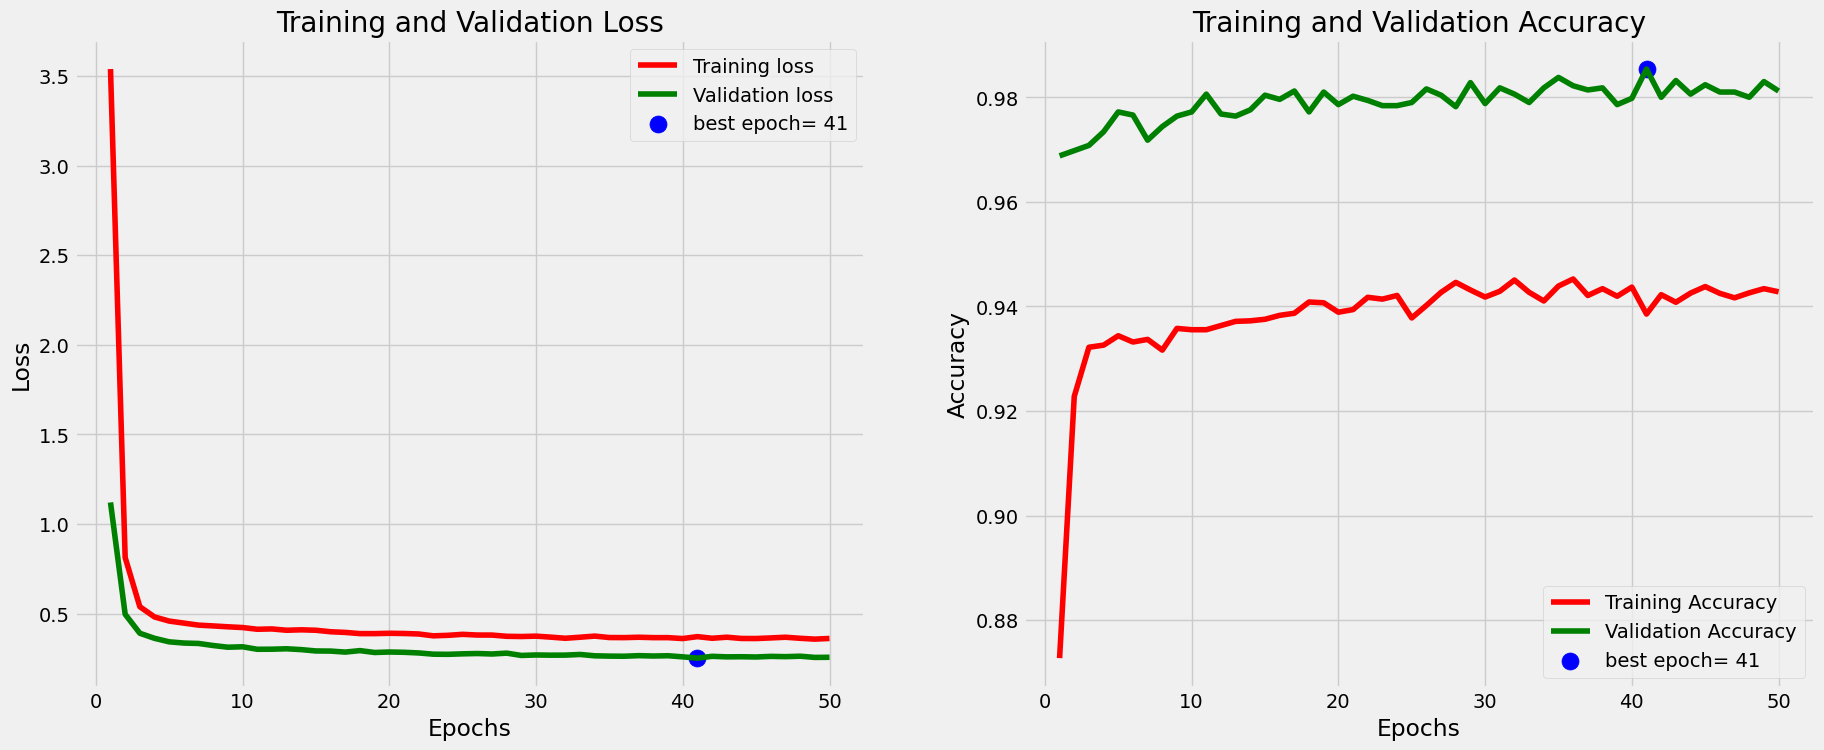

In [33]:
# Define 

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot 
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

## 8. Evaluate model

In [39]:
# Load and preprocess an image 
img_path = '/kaggle/input/testing-with-real-bottels/WIN_20231130_19_27_15_Pro.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create a batch
img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)  # Preprocess the image

# Predict 
predictions = model.predict(img_array)

predicted_class = np.argmax(predictions, axis=1)
print("Predicted class:", predicted_class)


1/1 [==============================] - 2s 2s/step
Predicted class: [1]
